# DKRZ Tutorial: &nbsp;&nbsp; Masking data using shapefiles

----

```text
Copyright 2024 Deutsches Klimarechenzentrum GmbH (DKRZ)
Licensed under CC-BY-NC-SA-4.0
```

----

In the field of data analysis and visualization, in some cases you want to use or display only the data of a certain geographical region. Selecting data of a certain region can be done, among other things, with the help of a shapefile for this region. Shapefiles contain georeferenced points, lines, and/or area features and can be downloaded from different sites.

In this tutorial we will use as sample data CDO's topography data set. In the first example we extract and draw the data for a single German state, in the second example for Germany, and in the third example we take a shapefile containing the features of almost all countries to draw the data for one selected country.

**Content**

- Function: shp_mask_var()
- Read a shapefile
- Generate sample data - topo<br>
  a. Plotting with ax.add_feature()<br>
  b. Plotting with ax.add_geometries()
- Example 1: Draw sample data of selected German state
- Example 2: Draw the data of variable topo of the area of Germany
- Example 3: Using the world countries.shp

**Shapefile description**

From the _ESRI Shapefile Technical Description_ <br>
https://www.esri.com/content/dam/esrisites/sitecore-archive/Files/Pdfs/library/whitepapers/pdfs/shapefile.pdf

> A shapefile stores nontopological geometry and attribute information for the spatial
features in a data set. The geometry for a feature is stored as a shape comprising a set of
vector coordinates.
> 
> Because shapefiles do not have the processing overhead of a topological data structure,
they have advantages over other data sources such as faster drawing speed and edit
ability. Shapefiles handle single features that overlap or that are noncontiguous. They
also typically require less disk space and are easier to read and write.
> 
> Shapefiles can support point, line, and area features. Area features are represented as
closed loop, double-digitized polygons. Attributes are held in a dBASE® format file.
Each attribute record has a one-to-one relationship with the associated shape record.

**Shapefiles used**
- gadm36_DEU_shp/gadm36_DEU_0.shp
- gadm36_DEU_shp/gadm36_DEU_1.shp
- countries_shp/countries.shp

**Learning content**
- Read shapefile content
- Extract polygon data of the choosen shapefile content
- Generate a mask array and use it to mask variable data
- Plot the masked data

**Shapefile download sites:** &nbsp;&nbsp;just google `shapefile download` &#x1F609;


<br>


In [1]:
import os
from datetime import datetime
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from cdo import Cdo
cdo = Cdo()

## Function: shp_mask_var()

This function reads the content of a shapefile, extracts the shapefile variable geometry data with the use of the given 'name' parameter, and generates the mask array. <br>
It uses **GeoPandas's** `read_file()` and **regionmask's** `Regions()` methods.

In [2]:
def shp_mask_var(ds, varname, shpfile, name, shpvar, lat_name='lat', lon_name='lon'):
    '''        
    Reads the shapefile content and extract the chosen name to be used to extract 
    the variable data.
    
    Keywords:
        ds        Dataset containing the variable and the dimensions time, lat, lon
        varname   data variable name
        shpfile   shapefile name
        shpvar    shapefile variable to extract, e.g. NAME_1
        lat_name  latitude coordinate name
        lon_name  longitude coordinate name
    
        returns   mask array
            
    Requirements: 
        geopandas
        regionmask
    '''
    #-- read the shapefile
    content = gpd.read_file(shpfile)
    #-- get the index of the given name in the shapefile
    index  = content[content[shpvar] == name].index.values
    #-- number of rows in GeoDataFrame
    nindex = content.index.size
    
    #-- create a Region object for the shapefile content
    content_mask = regionmask.Regions(name = list(content[shpvar])[0], 
                                      numbers = list(range(0,nindex)), 
                                      names = list(content[shpvar]), 
                                      abbrevs = list(content[shpvar]), 
                                      outlines = list(content.geometry.values[i] for i in range(0,nindex)))

    #-- create the mask array with same grid size as the data variable
    mask = content_mask.mask(ds, lat_name=lat_name, lon_name=lon_name)
    mask = mask.where(mask == index)

    #-- return the dataset that contains the variable data with the generated mask array
    return ds[varname].where(mask == index)

----

## Read a shapefile

The shapefile **gadm36_DEU_1.shp** contains the border polygons of the 16 federal states of Germany.

In [3]:
shp_file = os.environ['HOME']+'/data/Shapefiles/gadm36_DEU_shp/gadm36_DEU_1.shp'

Read the shapefile content using **GeoPandas's** `read_file()` method.

In [4]:
gdf = gpd.read_file(shp_file)

#-- print the first 3 rows
print(gdf.head(3))

  GID_0   NAME_0    GID_1             NAME_1 VARNAME_1  NL_NAME_1     TYPE_1  \
0   DEU  Germany  DEU.1_1  Baden-Württemberg       NaN        NaN       Land   
1   DEU  Germany  DEU.2_1             Bayern   Bavaria        NaN  Freistaat   
2   DEU  Germany  DEU.3_1             Berlin       NaN        NaN       Land   

  ENGTYPE_1 CC_1 HASC_1                                           geometry  
0     State   08  DE.BW  MULTIPOLYGON (((8.70802 47.68958, 8.70766 47.6...  
1       NaN   09  DE.BY  POLYGON ((9.74066 47.55354, 9.74058 47.55311, ...  
2     State   11  DE.BE  POLYGON ((13.17136 52.39776, 13.17135 52.39770...  


### Generate sample data - topo

Here, we use the `topo` operator of **CDO** to generate a global 0.1°x0.1° topography sample data set.

In [5]:
cdo.remapnn('global_0.1', input='-topo', options='-O -f nc', output='topo.nc')

var_name = 'topo'
ds = xr.open_dataset('topo.nc')
#ds.topo

----

## Example 1: Draw sample data of selected German state

The first example shows how to extract the geometry data of a single state from the shapefile and use it to generate the mask array.

In [6]:
name = 'Niedersachsen'
#name = 'Schleswig-Holstein'
#name = 'Bayern'

The geometry data for each German state is stored in the shapefile variable **NAME_1** in the **gadm36_DEU_1.shp** file.

In [7]:
shp_var = 'NAME_1'

**a. Plotting with ax.add_feature()**

Get the shapefile polygon of the choosen German state.

In [8]:
reader = shpreader.Reader(shp_file)
country = [polygon for polygon in reader.records() if polygon.attributes[shp_var] == name][0]

In [9]:
#country.geometry

Use the function **shp_mask_var** to generate the masked data.

In [10]:
masked_data = shp_mask_var(ds, var_name, shp_file, name, shp_var)

#masked_data

Create the plot and zoom into the map to display the area of Germany. Here, we use the `ax.add_feature()` method to add the geometries for drawing the German state border line at the end.

run time: 0:00:08.143813



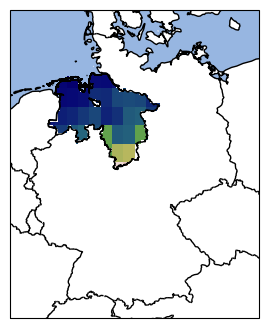

In [11]:
start_time = datetime.now() 

projection = ccrs.Mercator()

fig, ax = plt.subplots(figsize=(4,4), subplot_kw=dict(projection = projection))

ax.set_extent([5., 16., 47., 55.5])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

plot = ax.pcolormesh(ds.lon.values, 
                     ds.lat.values, 
                     masked_data,
                     cmap='gist_earth',
                     transform=ccrs.PlateCarree())

shape_feature = cfeature.ShapelyFeature([country.geometry], 
                                        ccrs.PlateCarree(), 
                                        facecolor='none', 
                                        edgecolor='black', 
                                        linewidth=1)
ax.add_feature(shape_feature)

print(f'run time: {datetime.now() - start_time}\n')

**b. Plotting with ax.add_geometries()**

In addition to the `ax.add_feature` method, the `ax.add_geometries` method can also be used to add the geometries.

```python
country1 = gpd.read_file(shp_file).loc[gdf[shp_var] == name]

fig, ax = plt.subplots(figsize=(4,4), subplot_kw=dict(projection = ccrs.Mercator()))

ax.set_extent([5., 16., 47., 55.5])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

plot = ax.pcolormesh(ds.lon.values, 
                     ds.lat.values, 
                     masked_data,
                     cmap='gist_earth',
                     transform=ccrs.PlateCarree())

style_kw = dict(facecolor='none', edgecolor='black', linewidth=1)
shape_feature = ax.add_geometries(country1.geometry, 
                                  crs=ccrs.PlateCarree(), 
                                  **style_kw,)
```

<br>

----

## Example 2: Draw the variable in the area of Germany

In the next example we use another shapefile **gadm36_DEU_0.shp** (not to be confused with _gadm36_DEU_1.shp_) that contains the border polygons of Germany.

The code is more or less the same as the code from the first example. But take care about the changed shapefile name and its variable name **NAME_0**.

In [12]:
shp_file2 = '/Users/k204045/data/Shapefiles/gadm36_DEU_shp/gadm36_DEU_0.shp'

name2 = 'Germany'

shp_var2 = 'NAME_0'

reader2  = shpreader.Reader(shp_file2)
country2 = [polygon for polygon in reader2.records() if polygon.attributes[shp_var2] == name2][0]

# Generate the mask array and assign the result to the variable
masked_data2 = shp_mask_var(ds, var_name, shp_file2, name2, shp_var2)

Create the plot and zoom into the map to display the area of Germany.

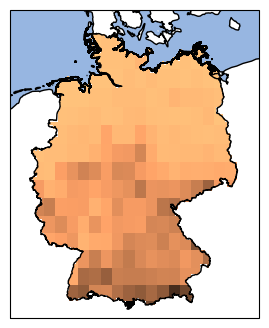

In [13]:
projection = ccrs.Mercator()

fig, ax = plt.subplots(figsize=(4,4), subplot_kw=dict(projection=projection))

ax.set_extent([5., 16., 47., 55.5])
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

plot = ax.pcolormesh(ds.lon.values, 
                     ds.lat.values, 
                     masked_data2,
                     cmap='copper_r', 
                     transform=ccrs.PlateCarree())

shape_feature = cfeature.ShapelyFeature([country2.geometry], 
                                        ccrs.PlateCarree(), 
                                        facecolor='none', 
                                        edgecolor='black', 
                                        linewidth=1)
ax.add_feature(shape_feature);

<br>

----

## Example 3: Using the world countries.shp

In the following example we have the global topography data set and want to plot the data of a country. Therefore, we use another shapefile that contains the geometries of the countries of the world.

We use the same code as before but have to modify the shapefile name, shapefile variable name and country.

Try to extract the data for the areas of the following countries:
- Australia
- United States 
- China
- Antarctica


In [14]:
shp_file3 = os.environ['HOME']+'/data/Shapefiles/countries_shp/countries.shp'

Have a look at the variables in the shapefile.

In [15]:
gpd.read_file(shp_file3).columns

Index(['OBJECTID', 'NAME', 'ISO3', 'ISO2', 'FIPS', 'COUNTRY', 'ENGLISH',
       'FRENCH', 'SPANISH', 'LOCAL', 'FAO', 'WAS_ISO', 'SOVEREIGN',
       'CONTINENT', 'UNREG1', 'UNREG2', 'EU', 'SQKM', 'geometry'],
      dtype='object')

The shapefile variable **NAME** contains the names of the countries.

In [16]:
content = gpd.read_file(shp_file3)

#-- print first 5 country names
for x in content['NAME'][0:5]:
        print(x)

Åland
Afghanistan
Albania
Algeria
American Samoa


Next, we choose the country that we want to extract and generate the masked data.

In [17]:
# Choose the country that has to be masked
#name3 = 'Australia'
#name3 = 'United States'
#name3 = 'China'
#name3 = 'Antarctica'
name3 = 'Canada'

# Select the shapefile variable that contains the polygons for the countries
shp_var3 = 'NAME'

# read shapefile content
reader3 = shpreader.Reader(shp_file3)

# return the polygon of the selected name
country3 = [polygon for polygon in reader3.records() if polygon.attributes[shp_var3] == name3][0]

# Generate the mask array and assign the result to the variable masked_data
masked_data3 = shp_mask_var(ds, var_name, shp_file3, name3, shp_var3)

Create the plot.

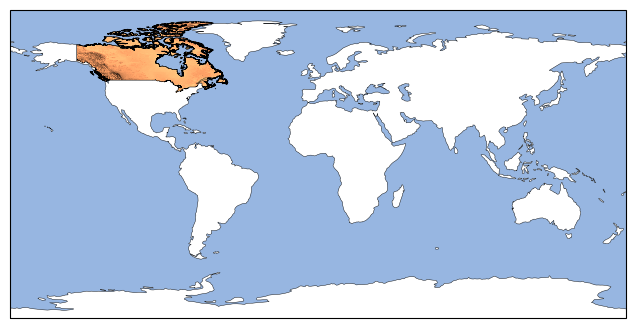

In [18]:
fig, ax = plt.subplots(figsize=(8,4), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_global()
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

plot = ax.pcolormesh(ds.lon.values, 
                     ds.lat.values, 
                     masked_data3,
                     vmin=0.,
                     cmap='copper_r', 
                     transform=ccrs.PlateCarree())

shape_feature3 = cfeature.ShapelyFeature([country3.geometry], 
                                          ccrs.PlateCarree(), 
                                          facecolor='none', 
                                          edgecolor='black', 
                                          linewidth=0.4)
ax.add_feature(shape_feature3);

<br>

----

Zoom in on the map 🔎


In [ ]:
fig, ax = plt.subplots(figsize=(10,10), 
                       subplot_kw=dict(projection=ccrs.Orthographic(central_longitude=-92, 
                                                                    central_latitude=62)))

ax.set_extent([-127., -57., 41., 84.], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'), lw=0.3, facecolor='none', edgecolor='black')
#ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.gridlines(color='gray', linestyle='--',)

plot = ax.pcolormesh(ds.lon.values, 
                     ds.lat.values, 
                     masked_data3,
                     vmin=0.,
                     cmap='copper_r', 
                     transform=ccrs.PlateCarree())

shape_feature3 = cfeature.ShapelyFeature([country3.geometry], 
                                          ccrs.PlateCarree(), 
                                          facecolor='none', 
                                          edgecolor='black', 
                                          linewidth=0.4)
ax.add_feature(shape_feature3);

And further zoom in on the west coast 🔎

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), 
                       subplot_kw=dict(projection=ccrs.Orthographic(central_longitude=-126, 
                                                                    central_latitude=50)))
ax.set_extent([-133., -122., 48., 55.], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.gridlines(color='gray', linestyle='--',)

plot = ax.pcolormesh(ds.lon.values, 
                     ds.lat.values, 
                     masked_data3,
                     vmin=0.,
                     cmap='copper_r', 
                     transform=ccrs.PlateCarree())

shape_feature3 = cfeature.ShapelyFeature([country3.geometry], 
                                          ccrs.PlateCarree(), 
                                          facecolor='none', 
                                          edgecolor='black', 
                                          linewidth=0.4)
ax.add_feature(shape_feature3);